In [4]:
import os
import numpy as np
from PIL import Image
from scipy.io import loadmat
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Dataset Paths
datasets_train = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth")
]

datasets_test = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth")
]

In [7]:
# Parameters
IMAGE_SIZE = (300, 300)
NUM_CLASSES = 2  # Low, High crowd density classes

# Extract head count from ground truth
def get_head_count(gt_file_path):
    gt_data = loadmat(gt_file_path)
    head_count = len(gt_data["image_info"][0][0][0][0][0])
    return head_count

# Load EfficientNetB3 as feature extractor
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
global_avg_layer = GlobalAveragePooling2D()

# Preprocess images and extract features
def load_features_and_labels(dataset_paths):
    features = []
    labels = []
    for dataset_path, ground_truth_path in dataset_paths:
        image_files = sorted(os.listdir(dataset_path), key=lambda x: int(x.split('_')[1].split('.')[0]))
        for img_file in image_files:
            img_path = os.path.join(dataset_path, img_file)
            gt_file = os.path.join(ground_truth_path, f"GT_{os.path.splitext(img_file)[0]}.mat")

            if os.path.exists(gt_file):
                head_count = get_head_count(gt_file)

                img = Image.open(img_path).convert('RGB')
                img_resized = img.resize(IMAGE_SIZE)
                img_array = np.array(img_resized) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                feature = base_model.predict(img_array, verbose=0)
                pooled_feature = global_avg_layer(feature).numpy().flatten()

                features.append(pooled_feature)

                if head_count <= 160:
                    labels.append(0)  # Low Density
                else:
                    labels.append(1)  # High Density
    return np.array(features), np.array(labels)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Load training and testing data
train_features, train_labels = load_features_and_labels(datasets_train)
test_features, test_labels = load_features_and_labels(datasets_test)

# Train Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_labels)

LogisticRegression(max_iter=1000)

Test Accuracy: 78.31%
Classification Report:
               precision    recall  f1-score   support

 Low Density       0.75      0.85      0.80       252
High Density       0.83      0.71      0.76       246

    accuracy                           0.78       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.79      0.78      0.78       498



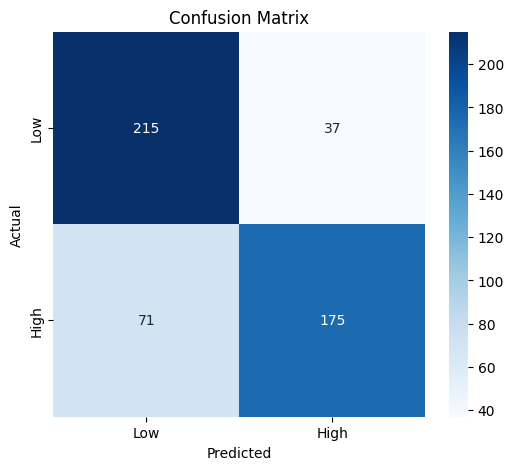

In [9]:
# Evaluate the model
accuracy = log_reg.score(test_features, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = log_reg.predict(test_features)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Compute classification metrics
report = classification_report(test_labels, y_pred, target_names=['Low Density', 'High Density'])

# Print metrics
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()